# Day 2 Neural Nets | CNN Classifier - Dogs vs. Cats Dataset 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🐶🐱 CNN Classifier - Dogs vs. Cats

In this notebook, we will build a CNN (Convolutional Neural Network) from scratch to classify images of cats and dogs using TensorFlow and Keras.

We'll go through:
- Loading and exploring the data
- Preprocessing and augmenting images
- Building a CNN model
- Training the model
- Evaluating performance

Let's start!


## ✅ Step 1: Setting Up & Understanding the Dataset
### 📌 What are we doing?
Before building a CNN, we need to:

- Understand the dataset we'll be using.
- Set up our environment with the right imports.
- Verify if the dataset is available directly through Keras or if we need to load it manually.

### 📦 Dataset: Dogs vs. Cats
The Dogs vs. Cats dataset is not available directly in tf.keras.datasets. It was part of a Kaggle competition, so:
- You need to use Kaggle Datasets to access it.
- The dataset typically comes as two ZIP files:

- `train.zip` – contains labeled dog and cat images.
- `test1.zip` – contains unlabeled test images.

In Kaggle Notebooks, you can add it from "Add data" → search for "dogs vs cats" (official competition dataset).

In [5]:
# Basic libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# For extracting zip files

from zipfile import ZipFile


In [6]:
import os
import shutil
import random

# Original paths (update if your input path is different)
cat_src = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
dog_src = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

# Target directories
base_dir = '/kaggle/working/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for category in ['cats', 'dogs']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)


## 📂 Step 2: Load & Explore the Dataset
### 🎯 What we’ll do:
- Create a proper directory structure: train/ and val/ folders, each with cats/ and dogs/ inside.
- Randomly split the images into training and validation sets (e.g., 80/20).
- Prepare them for loading using ImageDataGenerator.

In [7]:
from tqdm import tqdm

def split_data(src_dir, train_dst, val_dst, split_ratio=0.8):
    files = os.listdir(src_dir)
    random.shuffle(files)
    split_idx = int(len(files) * split_ratio)

    train_files = files[:split_idx]
    val_files = files[split_idx:]

    for f in tqdm(train_files, desc="Copying train files"):
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dst, f))
    for f in tqdm(val_files, desc="Copying val files"):
        shutil.copy(os.path.join(src_dir, f), os.path.join(val_dst, f))


# Split cats
split_data(cat_src,
           os.path.join(train_dir, 'cats'),
           os.path.join(val_dir, 'cats'))

# Split dogs
split_data(dog_src,
           os.path.join(train_dir, 'dogs'),
           os.path.join(val_dir, 'dogs'))


Copying val files: 100%|██████████| 2501/2501 [00:12<00:00, 199.74it/s]


## 🧼 Step 3: Preprocessing & Data Augmentation
### 🎯 What are we doing?
- Rescale images (pixel values 0–1 instead of 0–255)
- Augment training images (to help generalize better)
- Load images in batches using ImageDataGenerator.flow_from_directory

### ⚙️ Preprocessing with ImageDataGenerator
Keras makes this super easy:

- `Training Generator`:
Rescale + Augmentation (rotation, zoom, flip)

- `Validation Generator`:
Just rescale (no augmentation for validation!)



In [8]:
# Image size expected by our CNN
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (only rescale)
val_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
# Load training data from folder
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Because it's a 2-class problem
)

# Load validation data from folder
val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/data/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 19998 images belonging to 2 classes.
Found 5002 images belonging to 2 classes.


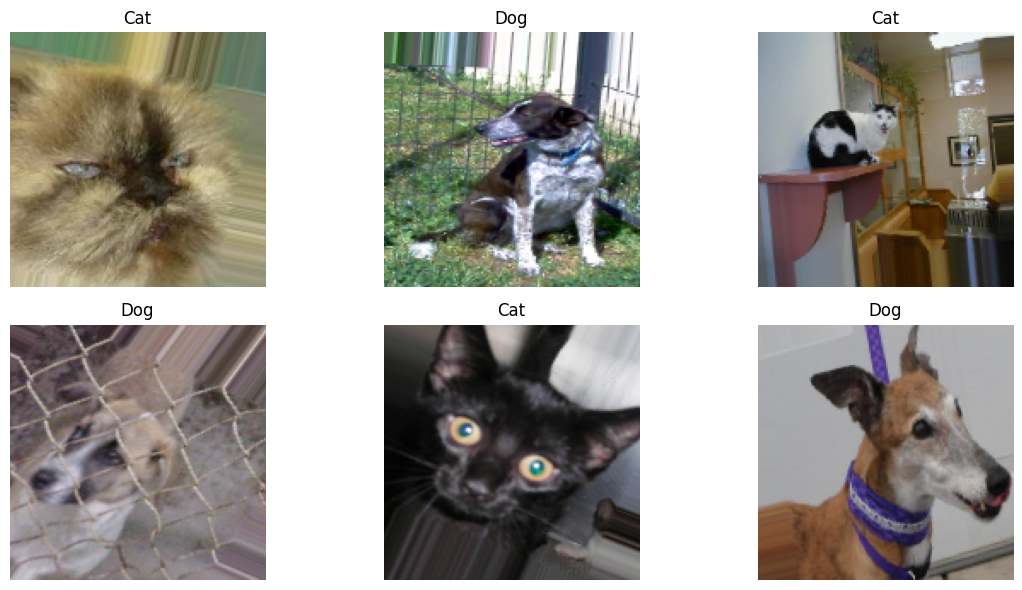

In [10]:
images, labels = next(train_generator)  # One batch

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title("Dog" if labels[i] == 1 else "Cat")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 🏗️ Step 4: Build the CNN Model
### 🎯 What are we doing?
We’ll create a simple but effective Convolutional Neural Network (CNN) using Keras Sequential API.
Our architecture will look like this:

`Conv → MaxPool`

`Conv → MaxPool`

`Conv → MaxPool`

`Flatten → Dense → Dropout → Output`
### ✅ Why CNN Works for Images:
- Convolution Layers learn features like edges, curves, and textures.

- Pooling Layers reduce spatial size (downsampling).

- Fully Connected Layers make the final prediction.

In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Layer 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),

    # Layer 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Layer 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten + Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary output
])


In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Step 5: Train the Model
### 🎯 What are we doing?
Now that our model is built and compiled, we'll:

- Train it using the training generator

- Validate it using the validation generator

- Track accuracy and loss during training

### ⚙️ Basic Training Settings
- Epochs: 10 (you can increase later)

- Steps per epoch: number of batches per epoch (num_train_images // batch_size)

- Validation steps: same for validation

`Tip: Kaggle GPU helps training go faster – make sure it's enabled!`



> ( PS an error occured, let's fix it before training - ⚠️ What's Happening:
Your model training is crashing because one or more files in your dataset folder aren't valid image files. The error: `UnidentifiedImageError: cannot identify image file`
> ### ✅ Fix Plan
We'll scan through your dataset folders and remove anything that is not a valid image.

In [15]:
from PIL import Image, UnidentifiedImageError

def remove_invalid_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if it's an image
            except (UnidentifiedImageError, IOError, SyntaxError):
                print(f"❌ Removing invalid image: {file_path}")
                os.remove(file_path)

# Clean both train and val folders
remove_invalid_images('/kaggle/working/data/train')
remove_invalid_images('/kaggle/working/data/val')


❌ Removing invalid image: /kaggle/working/data/train/cats/Thumbs.db
❌ Removing invalid image: /kaggle/working/data/train/dogs/Thumbs.db
❌ Removing invalid image: /kaggle/working/data/train/dogs/11702.jpg


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


❌ Removing invalid image: /kaggle/working/data/val/cats/666.jpg


In [16]:
# Re-initialize the generators to refresh file list
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/data/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 19997 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.


In [17]:
EPOCHS = 25

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)



Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745060653.866501      95 service.cc:148] XLA service 0x7a4504003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745060653.867131      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745060654.184184      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/624 ━━━━━━━━━━━━━━━━━━━━ 1:15:47 7s/step - accuracy: 0.6562 - loss: 0.6948

I0000 00:00:1745060657.272608      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


624/624 ━━━━━━━━━━━━━━━━━━━━ 124s 188ms/step - accuracy: 0.5462 - loss: 0.6949 - val_accuracy: 0.7133 - val_loss: 0.5581
Epoch 2/25
  1/624 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5938 - loss: 0.6757

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.5938 - loss: 0.6757 - val_accuracy: 0.4444 - val_loss: 0.6992
Epoch 3/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.6876 - loss: 0.5830 - val_accuracy: 0.7574 - val_loss: 0.5035
Epoch 4/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.7500 - loss: 0.5132 - val_accuracy: 0.7778 - val_loss: 0.4942
Epoch 5/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 115s 183ms/step - accuracy: 0.7367 - loss: 0.5286 - val_accuracy: 0.7756 - val_loss: 0.4621
Epoch 6/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.7812 - loss: 0.4758 - val_accuracy: 1.0000 - val_loss: 0.2772
Epoch 7/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 116s 184ms/step - accuracy: 0.7600 - loss: 0.4949 - val_accuracy: 0.7999 - val_loss: 0.4345
Epoch 8/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.8438 - loss: 0.3930 - val_accuracy: 1.0000 - val_loss: 0.1764
Epoch 9/25
624/624 ━━━━━━━━━━━━━━━━━━━━ 115s 182ms/step - accuracy: 0.7856 - loss: 0.4578 - val_ac

## 🧪 Step 6: Evaluate & Predict
Now that your model is trained, we’ll:

- Evaluate its performance on validation/test data.
- Predict on custom new images (you can upload or pick from the dataset).
- Visualize predictions.



### ✅ 6.1 – Evaluate Model on Validation Data

In [18]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8738 - loss: 0.2904
Validation Accuracy: 0.8762
Validation Loss: 0.2837


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


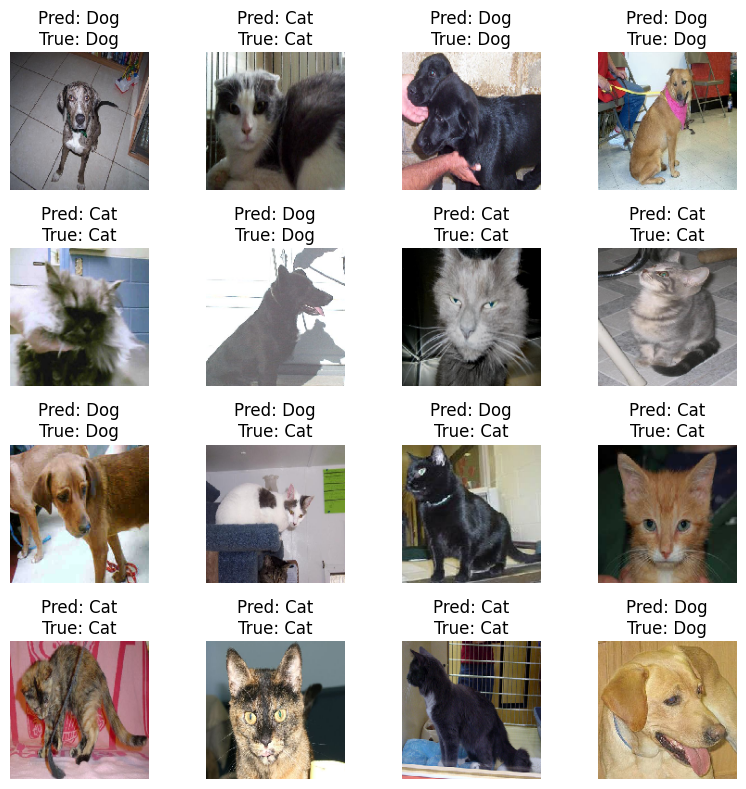

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming val_generator yields batches where the first element is a batch of images
# and the second element is a batch of corresponding labels.
# Assuming your model.predict(images) returns predictions where the first element
# of the prediction for each image is the probability of it belonging to class 'Dog' (e.g., > 0.5 is Dog).

# Generate a batch of 25 data points
batch = next(val_generator)
images, labels = batch[0], batch[1]

# Ensure we have at least 25 data points
num_samples = min(16, len(images))
images = images[:num_samples]
labels = labels[:num_samples]

# Get predictions for the selected images
preds = model.predict(images)

# Determine the layout of the square grid
grid_size = int(np.ceil(np.sqrt(num_samples)))

plt.figure(figsize=(2 * grid_size, 2 * grid_size))
for i in range(num_samples):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(images[i])
    pred_label = 'Dog' if preds[i][0] > 0.5 else 'Cat'
    true_label = 'Dog' if labels[i] == 1 else 'Cat'
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

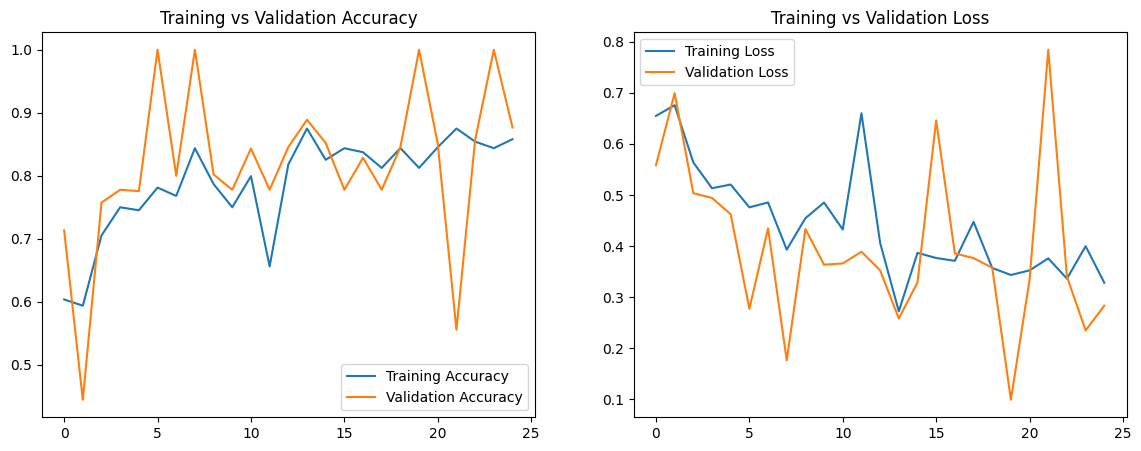

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')

    plt.show()

plot_training_history(history)
